In [1]:
import numpy as np
import pandas as pd
from ase.io import read, write
from ase import units
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from scipy.stats import kstest
import statsmodels.api as sm


plt.rc('font', family="sans-serif", weight="bold")          # controls default text sizes
plt.rc('axes', labelsize=15, titlesize=15)    # x and y axes
plt.rc('xtick', labelsize=15)    # Major Ticks
plt.rc('ytick', labelsize=15)    # Major Ticks
plt.rc('xtick.minor', visible=True)    # Minor Ticks
plt.rc('ytick.minor', visible=True)    # Minor Ticks
plt.rc('legend', fontsize=10)    # Legend
plt.rc('figure', titlesize=10)  # Figure title


plt.rcParams['figure.dpi'] = 300
print(plt.rcParams['font.family'])

['sans-serif']


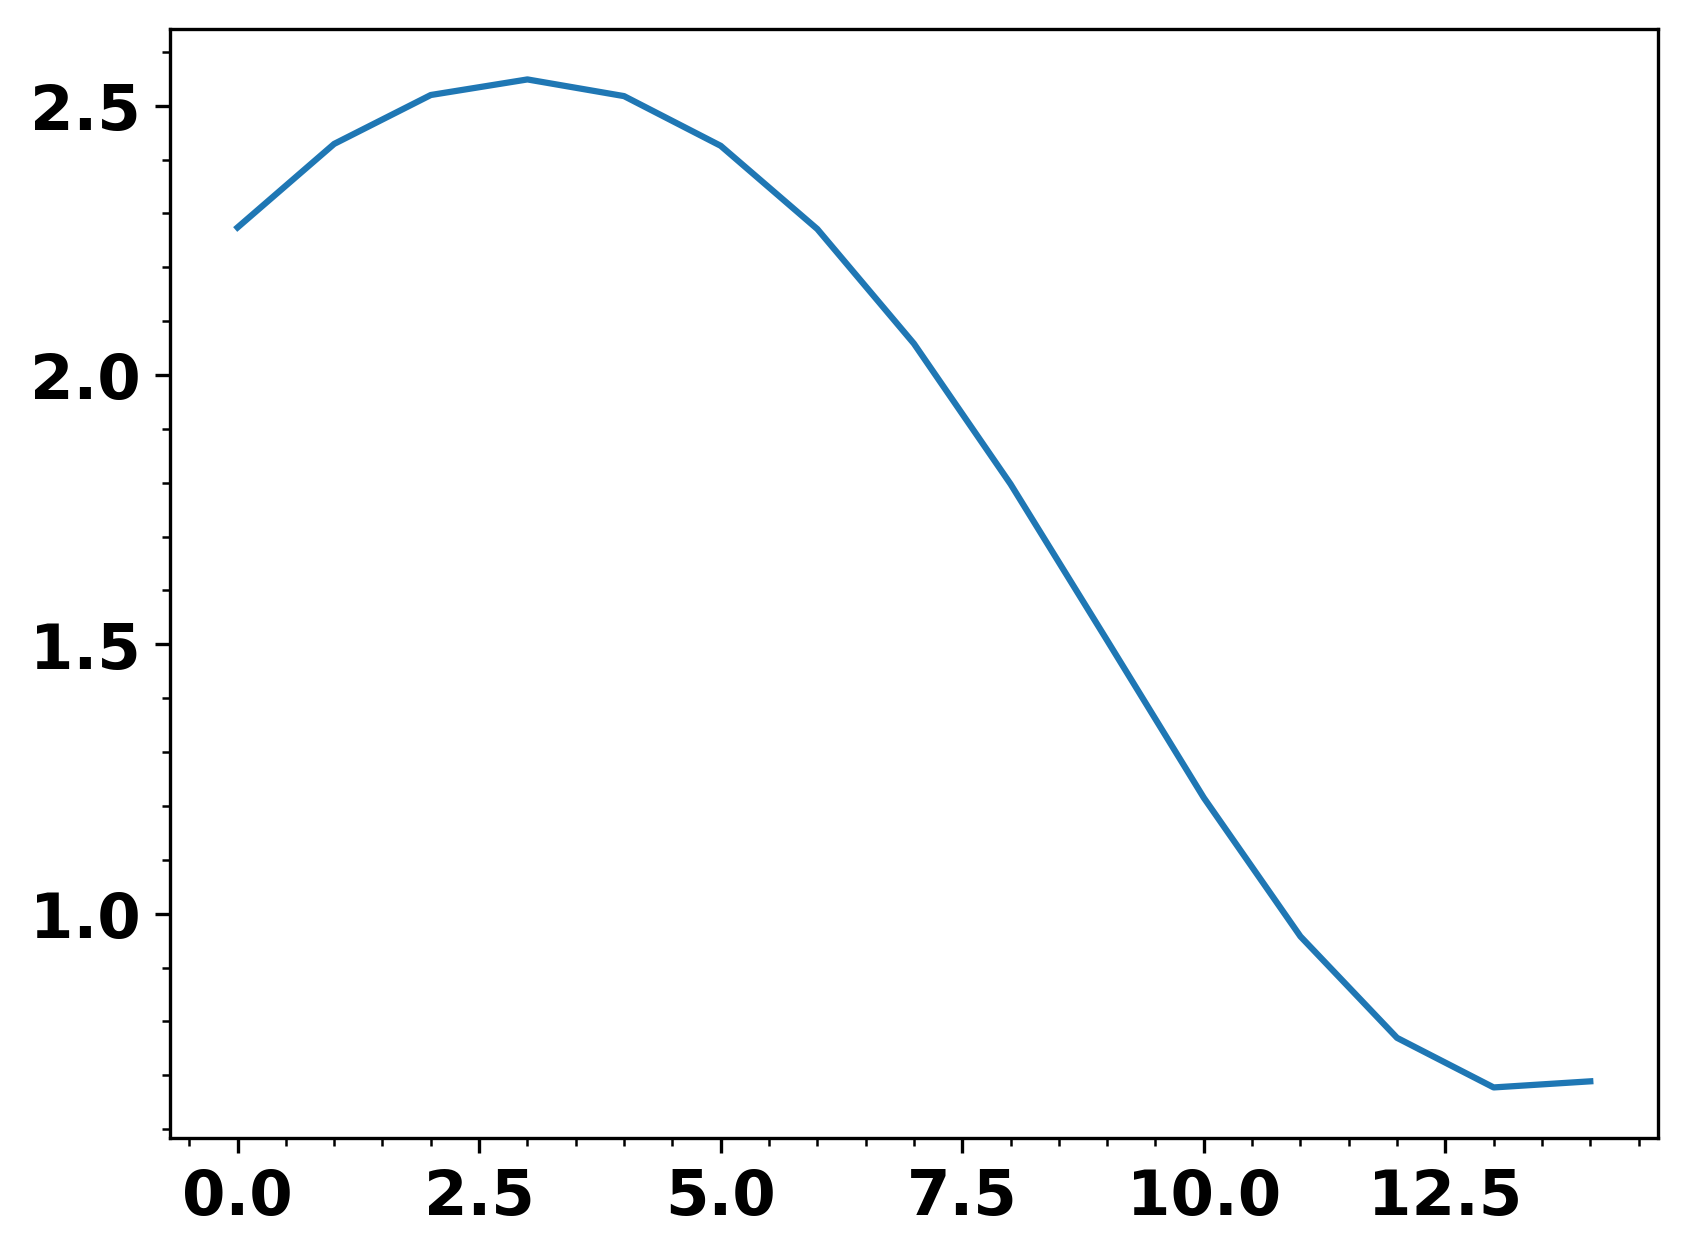

In [2]:
force = []
mol = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':')
for atom in mol:
    force.append(atom.get_forces()[2,0])

plt.plot(range(len(force[5020:5035])), force[5020:5035])

In [15]:
#The function takes arrays of forces and returns a VAR OLS model
#_____Inputs______
# main - 1D np array with the time series which the model fits to.
# secondary - 2D np array with the secondary time series used to predict the main time series
# order - Positive integer which decides the numper of points in the past is used to predict the next point
#
#_____Output______
# Returns a OLS model that uses the main and secondary time series to predict the main time series. In order to predict t+2 of the main timeseries,
# t+1 of both main and secondary time series must be known. If the values of the secondary time series is not known this can be done by also creating models
# for the secondary time series and use those to predict the value at t+1
def create_arima_model(main, order=2):
    return ARIMA(main, order=(order, 0, 0))

# Returns 3 fitted models from create_VAR_OLS_model to create 3 models to respectively predict the forces in x, y, and z direction for an atom in a molecule.
# Uses L2 regularized fitting.
#_____Inputs______
# forces - 2D np array with the three force time series for the atom chosen. Has the shape [N, 3] where N is the number of input points in the model.
# order - Positive integer which decides the numper of points in the past is used to predict the next point
#
#_____Output______
# Returns 3 fitted VAR OLS which can be used to predict future points in the time series. t+1 must be predicted for all three time series before t+2 can be predicted.
def create_atom_arima_model(forces, order=2):
    model_x = create_arima_model(forces[0,:], order=order)
    model_y = create_arima_model(forces[1,:], order=order)
    model_z = create_arima_model(forces[2,:], order=order)
    with model_x.fix_params({'const': 0}):
        model_x = model_x.fit()
    with model_y.fix_params({'const': 0}):
        model_y = model_y.fit()
    with model_z.fix_params({'const': 0}):
        model_z = model_z.fit()
    return model_x, model_y, model_z


# Function which predicts the forces on the atoms in a molecule for a certain number of time steps
#_____Inputs______
# file - String with the name of the xyz file containing information on the molecule
# input - Positive integer with the number of data points used as input in training the OLS VAR models
# pred_step - Positive integer which decides the number of time steps predicted by the OLS VAR models
# order - Positive integer which decides the numper of points in the past is used to predict the next point
#
#_____Output______
# Returns a 3D np array with the predicted forces. The array as the following shape [N, 3, p], with N being the number of atoms in the molecule
# and p being the number of time steps predicted
def predict_forces(mol, input=6, pred_step=1, order=2):
    #mol = read(file, index=slice(-input, None))
    n_atoms = mol[0].get_global_number_of_atoms()
    predicted_forces = np.zeros((n_atoms, 3, pred_step))
    forces = np.zeros((n_atoms, 3, input))

    for i in range(len(mol)):
        forces[:,:,i] = mol[i].get_forces()
    for i in range(n_atoms):
        model_x, model_y, model_z = create_atom_arima_model(forces[i,:,:], order=order)
        forecast_forces = np.zeros((3, pred_step))
        forecast_forces[0,:] = np.asarray(model_x.predict(start=input, end=input+pred_step-1))
        forecast_forces[1,:] = np.asarray(model_y.predict(start=input, end=input+pred_step-1))
        forecast_forces[2,:] = np.asarray(model_z.predict(start=input, end=input+pred_step-1))
        predicted_forces[i,:,:] = forecast_forces
        
    return predicted_forces


# Average difference in positions between timesteps

In [4]:
mol = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':')

av_position_difference = []

for i in range(len(mol)-1):
    av_position_difference.append(((np.abs(mol[i+1].get_positions()-mol[i].get_positions()))))
pos_dif = np.asanyarray(av_position_difference).flatten()
mean_diff, var_diff = np.mean(av_position_difference), np.var(av_position_difference)
print(np.mean(pos_dif), np.var(pos_dif))

0.007303561025867807 4.770192216813936e-05


# Evaluating model with input and pred

In [17]:
mae = []
k=0
def evaluate_model(mol, input=6, pred_step=6, dt=0.5*units.fs, model="AR", order=2):
    mae = []
    k=0
    while k < len(mol)-input-pred_step-20:
        print(k)
        if model == "AR":
            predicted_forces = predict_forces(mol[k:k+input], input=input, pred_step=pred_step, order=order)
        elif model =="ARIMA":
            predicted_forces = predict_forces(mol[k:k+input], input=input, pred_step=pred_step, order=order)
        else:
            print("Please choose a valid model")
            return
        temp_mol = mol[k+input-1]
        #Repurposing the step function from ASE velverlet
        for i in range(pred_step):
            #Get masses for the atoms in the molecule
            masses = temp_mol.get_masses()[:, np.newaxis]

            #Get the forces, momenta, and positions for the current step
            #forces = mol[i].get_forces()
            force_step = predicted_forces[:,:,i] 
            p = temp_mol.get_momenta()
            r = temp_mol.get_positions()
            
            #Calculate new momenta and positions
            p += 0.5 * dt * force_step
            temp_mol.set_positions(r + dt * p / masses)
            error = temp_mol.get_positions()-mol[k+input+i].get_positions()
            mae.append(np.abs(error))
            #Was in ase.step. Unsure if needed
            if temp_mol.constraints:
                p = (temp_mol.get_positions() - r) * masses / dt

            #Momenta needs to be stored before possible calculations of forces
            temp_mol.set_momenta(p, apply_constraint=False)

            #Forces for next step is found either using predicted forces or gpaw calculator
            if i<pred_step-1:
                force_step = predicted_forces[:,:,i+1]
            
            
            #Calculate and set momenta for the next step
            temp_mol.set_momenta(temp_mol.get_momenta() + 0.5 * dt * force_step)
        k+=input+pred_step
    return np.asarray(mae)

In [6]:
mol = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':5000')
input, pred_step = 4, 4
mae = evaluate_model(mol=mol, input=input, pred_step=pred_step, model="AR", order=2)

c:\Users\Birk Dissing\anaconda3\envs\MM\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Birk Dissing\anaconda3\envs\MM\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Birk Dissing\anaconda3\envs\MM\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Birk Dissing\anaconda3\envs\MM\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Birk 

KeyboardInterrupt: 

mae = 0.001511038344381281 +- 0.0013502919192891715
[0.01887124 0.0847117  0.22354502 0.50043456] [0.00012333 0.00056117 0.00169122 0.04185099]


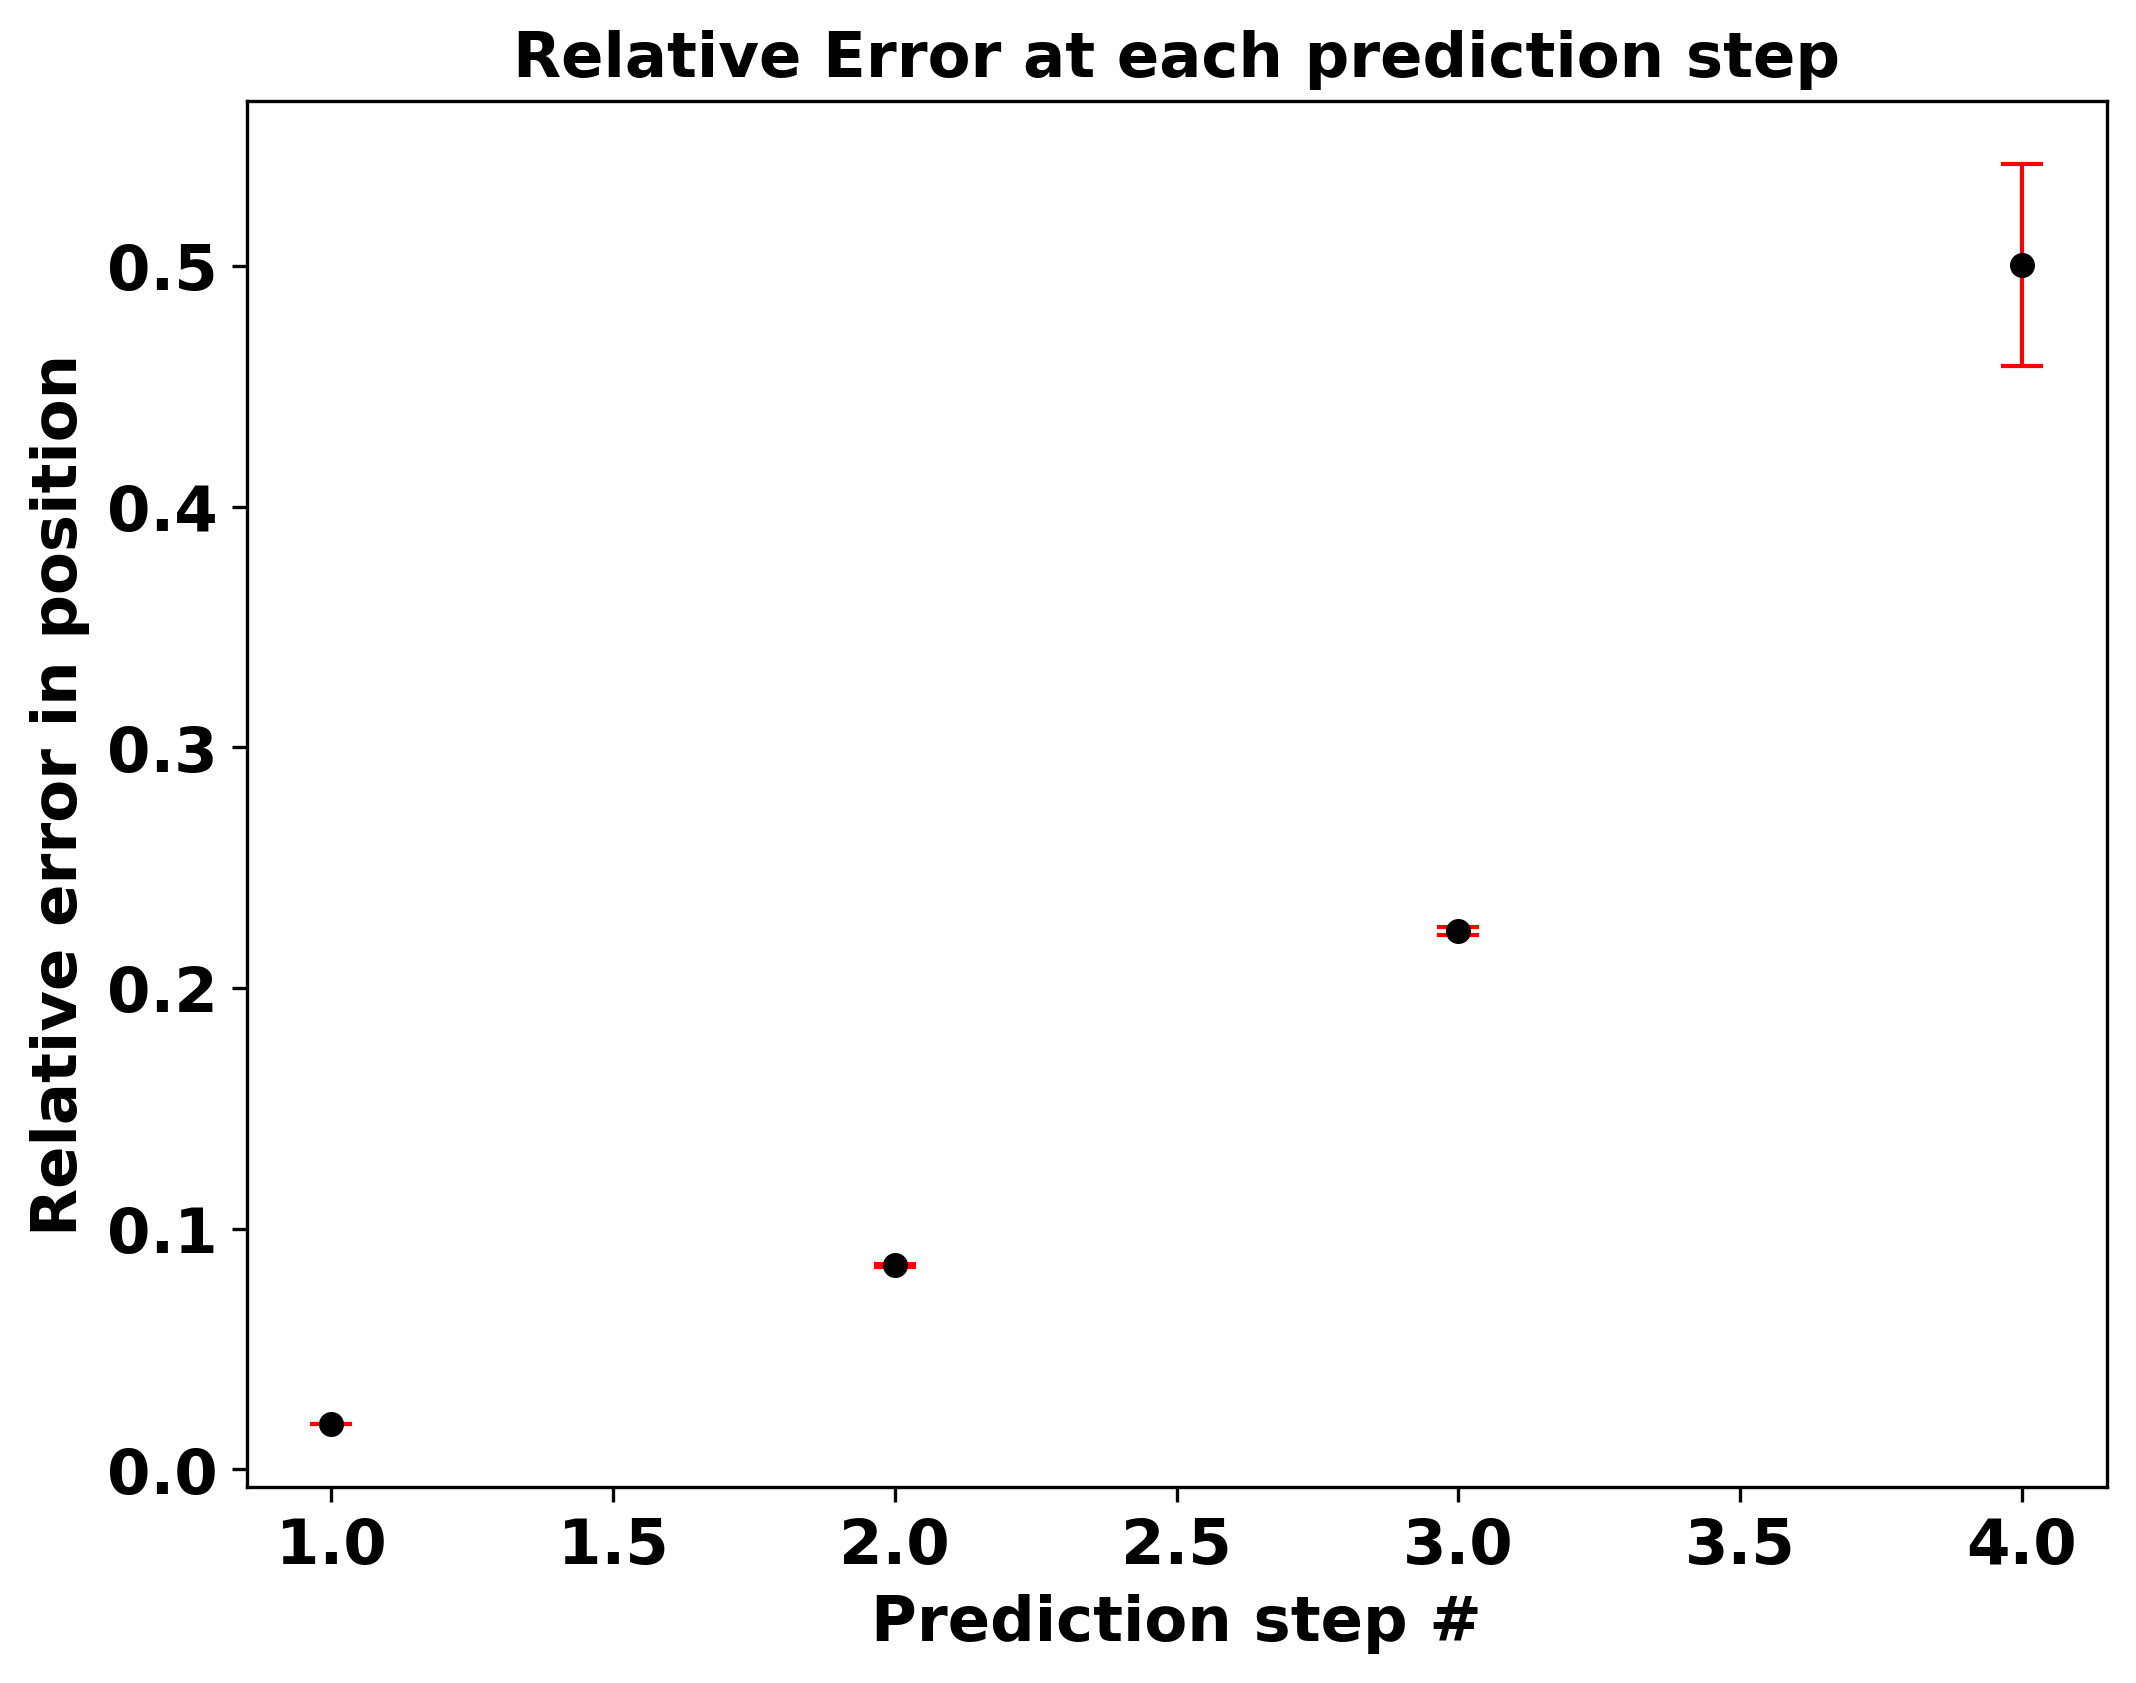

In [ ]:
mae_step = []
var_step = []

for i in range(pred_step):
    mae_step.append(np.mean(mae[i::pred_step,:,:]))
    var_step.append(np.var(mae[i::pred_step,:,:]))
mae_step, var_step = np.asarray(mae_step), np.asarray(var_step)
print("mae =",np.mean(mae_step), "+-", np.std(mae_step))
y_std = np.sqrt((var_step/mae_step)**2+(var_diff/mean_diff)**2)*mae_step/mean_diff
print(mae_step/mean_diff, y_std)

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(range(1, pred_step+1), mae_step/mean_diff, yerr=y_std, fmt='.k',  ecolor='r', elinewidth=1, capsize=5, capthick=1, ms=10)
#ax.set_xlim(0.5, 4.5)
#ax.set_ylim(0, 0.29)
ax.set_ylabel("Relative error in position", fontweight="bold")
ax.set_xlabel("Prediction step #", fontweight="bold")
ax.set_title("Relative Error at each prediction step", fontweight="bold")
ax.minorticks_off()

622.0
mae = 0.001511038344381281 +- 7.974291124225217e-05
[0.00013782723125380412, 0.00037826215779559883, 0.000796399664424107, 0.0015110383443812812]


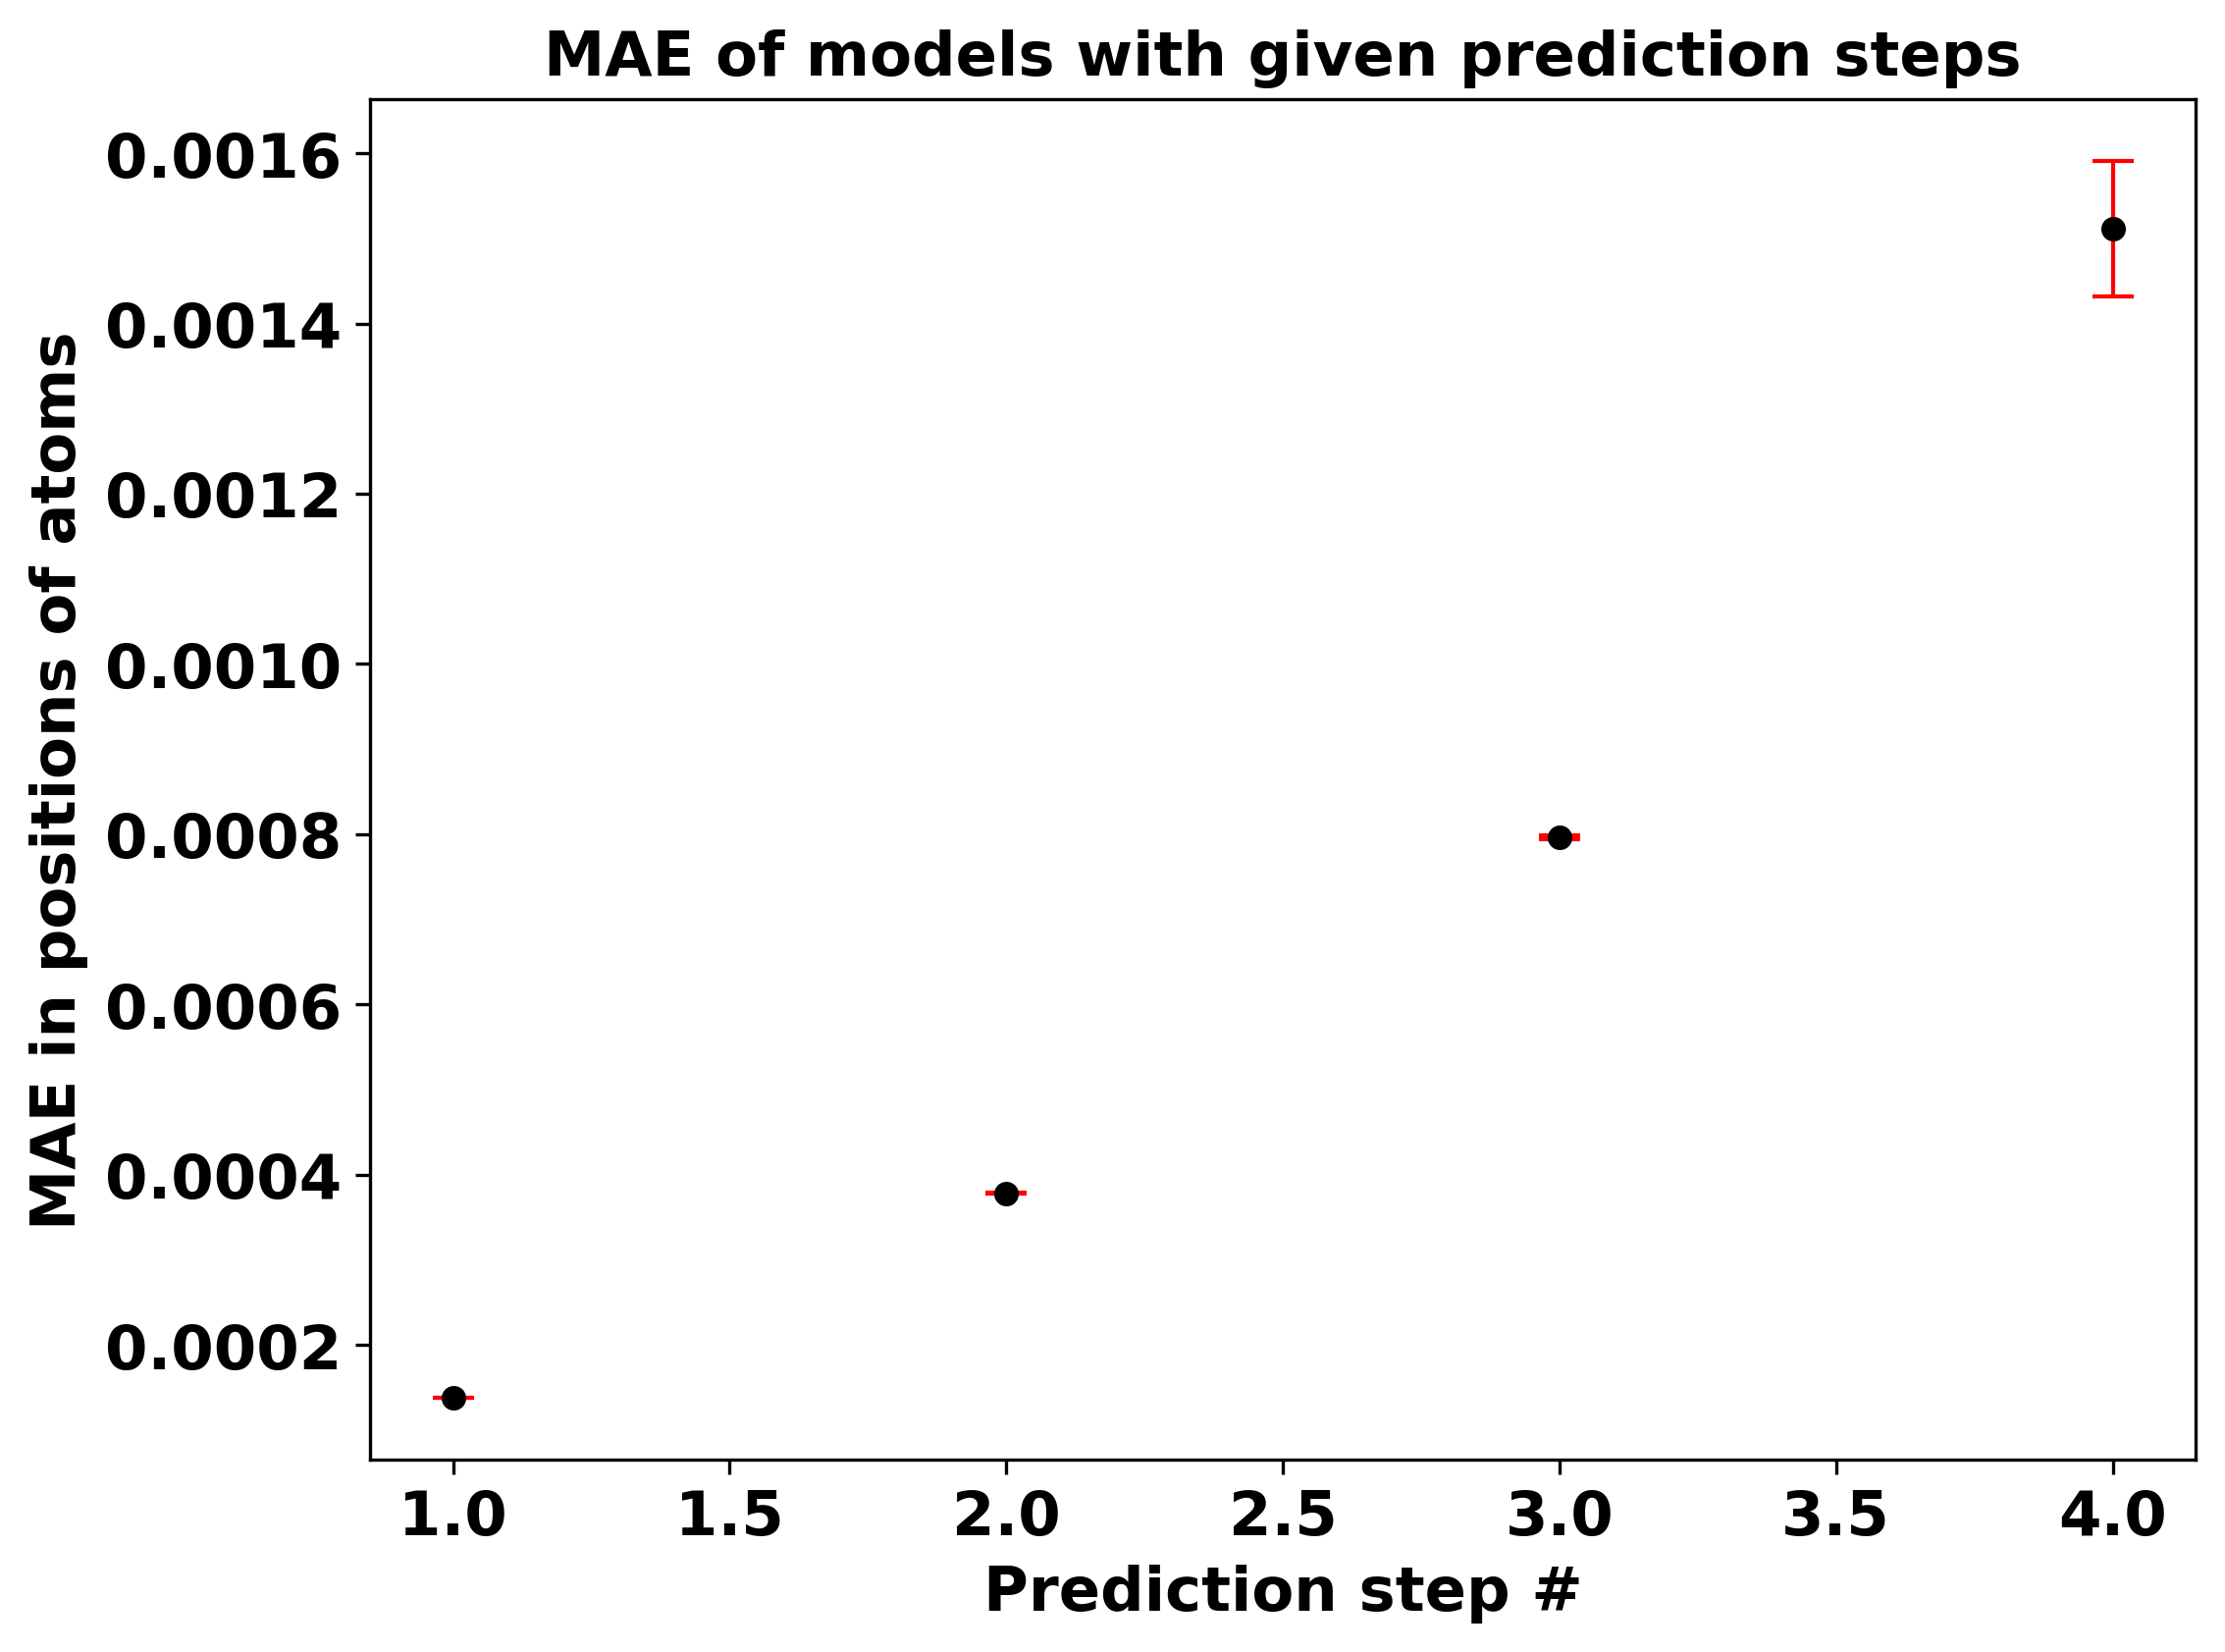

In [ ]:
print(len(mae)/pred_step)
mae_steps = np.ones([pred_step, int(len(mae)/pred_step), 9, 3])
mae_model = []
var_model = []


for i in range(pred_step):
    mae_steps[i,:,:,:] = mae[i::pred_step,:,:]

for i in range(pred_step):
    mae_model.append(np.mean(mae_steps[:i+1,:]))
    var_model.append(np.var(mae_steps[:i+1,:]))
print("mae =",np.mean(mae), "+-", np.var(mae))
print(mae_model)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(range(1, pred_step+1), mae_model, yerr=np.array(var_model), fmt='.k',  ecolor='r', elinewidth=1, capsize=5, capthick=1, ms=10)
#ax.set_xlim(0.5, 4.5)
#ax.set_ylim(0, 0.29)
ax.set_ylabel("MAE in positions of atoms", fontweight="bold")
ax.set_xlabel("Prediction step #", fontweight="bold")
ax.set_title("MAE of models with given prediction steps", fontweight="bold")
ax.minorticks_off()

# Heatmap of input and pred_step parameters

In [18]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

mae = np.zeros((13, 8))
for i in range(13):
    for j in range(8):
        mol = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':5000')
        print(i, j)
        mae[i, j] = np.mean(evaluate_model(mol=mol, input=i+4, pred_step=j+1, model="AR", order=2))
    
#np.save("mae_grid", mae)

#mae = np.load("mae_grid.npy")

0 0
0
[-0.12065796]


c:\Users\Birk Dissing\anaconda3\envs\MM\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


[0.74385545]
[1.47123495]
[-0.6961949]
[-0.57968525]
[0.17582553]
[-1.22151127]
[-0.07011822]
[-0.09081649]
5
[-1.63998571]
[-0.42682204]
[3.25643317]
[0.56412162]
[0.50417668]
[-0.77155559]
[0.85686335]
[-1.03669181]
[-1.36089927]
10
[-1.62693543]
[-1.38641087]
[2.44442707]
[0.78580291]
[0.72856513]
[-0.73947946]
[1.55941326]
[-0.90070549]
[-0.98781975]
15
[-0.17845145]
[-2.24750098]
[-0.41880352]
[-0.27965746]
[-0.12118975]
[0.4406508]
[1.13638991]
[0.3077935]
[1.14266017]
20
[2.36364431]
[-1.40355329]
[-0.97389103]
[-1.76051253]
[-1.56246404]
[1.4121559]
[-1.16973416]
[1.92972409]
[1.30651841]
25
[1.39519952]
[0.49678915]
[0.59222979]
[-0.4140991]
[-0.38618111]
[-0.02471801]
[-1.8991204]
[0.84702378]
[-0.75038617]
30
[-0.81219172]
[-0.2801]
[0.75167116]
[1.12841036]
[1.20055016]
[-1.04066768]
[0.8655297]
[-0.64818486]
[-1.12788746]
35
[-1.55835864]
[-0.20529019]
[-0.37371691]
[1.44250838]
[1.50046338]
[-0.99273024]
[1.65517636]
[-1.14409614]
[-0.37261876]
40
[-0.59977902]
[-0.152404

KeyboardInterrupt: 

In [ ]:
print(pd.DataFrame(mae))
#np.savetxt("mae_grid.csv", mae)

           0         1         2             3             4             5  \
0   0.000138  0.000380  0.000793      0.001511  2.565354e-03  6.881862e-03   
1   0.000186  0.250730  4.611102  33472.517519  1.081755e+11  2.435069e+14   
2   0.000129  0.000343  0.000733      0.026193  1.988227e-01  2.814817e-01   
3   0.000128  0.000324  0.000629      0.001088  1.786099e-03  3.195369e-03   
4   0.000127  0.000322  0.000616      0.001066  1.642357e-03  2.610814e-03   
5   0.000127  0.000323  0.000628      0.001027  1.666006e-03  2.609734e-03   
6   0.000127  0.000327  0.000613      0.001061  1.711146e-03  2.659366e-03   
7   0.000128  0.000319  0.000626      0.001079  1.761607e-03  2.707687e-03   
8   0.000126  0.000326  0.000638      0.001119  1.784641e-03  2.781432e-03   
9   0.000128  0.000328  0.000654      0.001128  1.826012e-03  2.889740e-03   
10  0.000128  0.000335  0.000655      0.001143  1.879264e-03  2.920120e-03   
11  0.000129  0.000332  0.000667      0.001156  1.895117e-03  2.

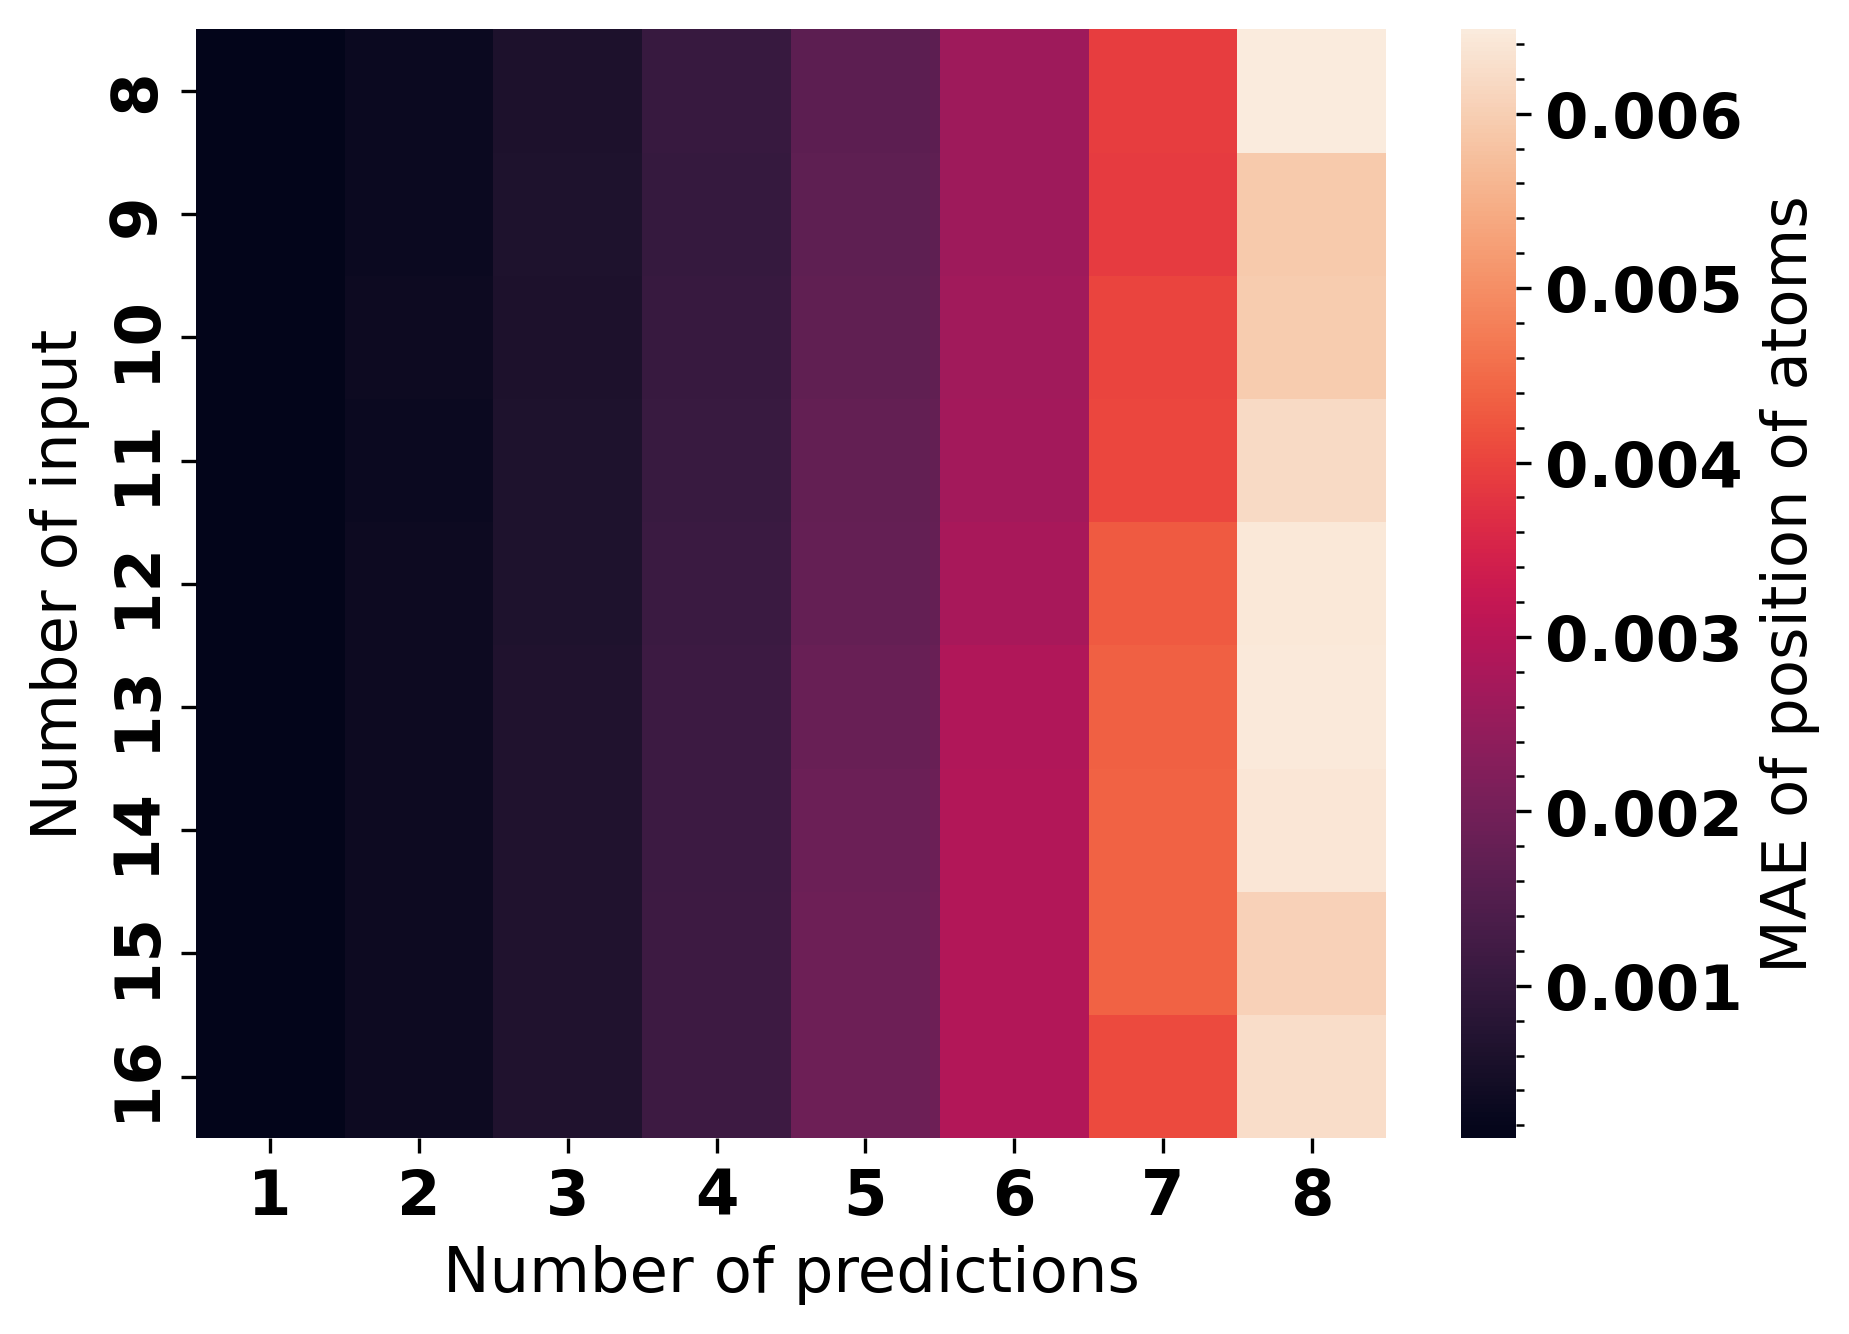

In [ ]:
ax = sns.heatmap(mae[4:,:], cbar_kws={'label':"MAE of position of atoms"})
ax.set(xlabel="Number of predictions", ylabel="Number of input")
ax.set_yticklabels(range(8, 17))
ax.set_xticklabels(range(1, 9))

ax.minorticks_off()

[1.32146058e-01 4.05774717e+21 9.67945303e+02 3.34239747e-02
 2.09864667e-03 2.02473720e-03 2.05745431e-03 2.10804339e-03
 2.18351693e-03 2.21926317e-03 2.23166518e-03 2.19138866e-03
 2.17981560e-03]


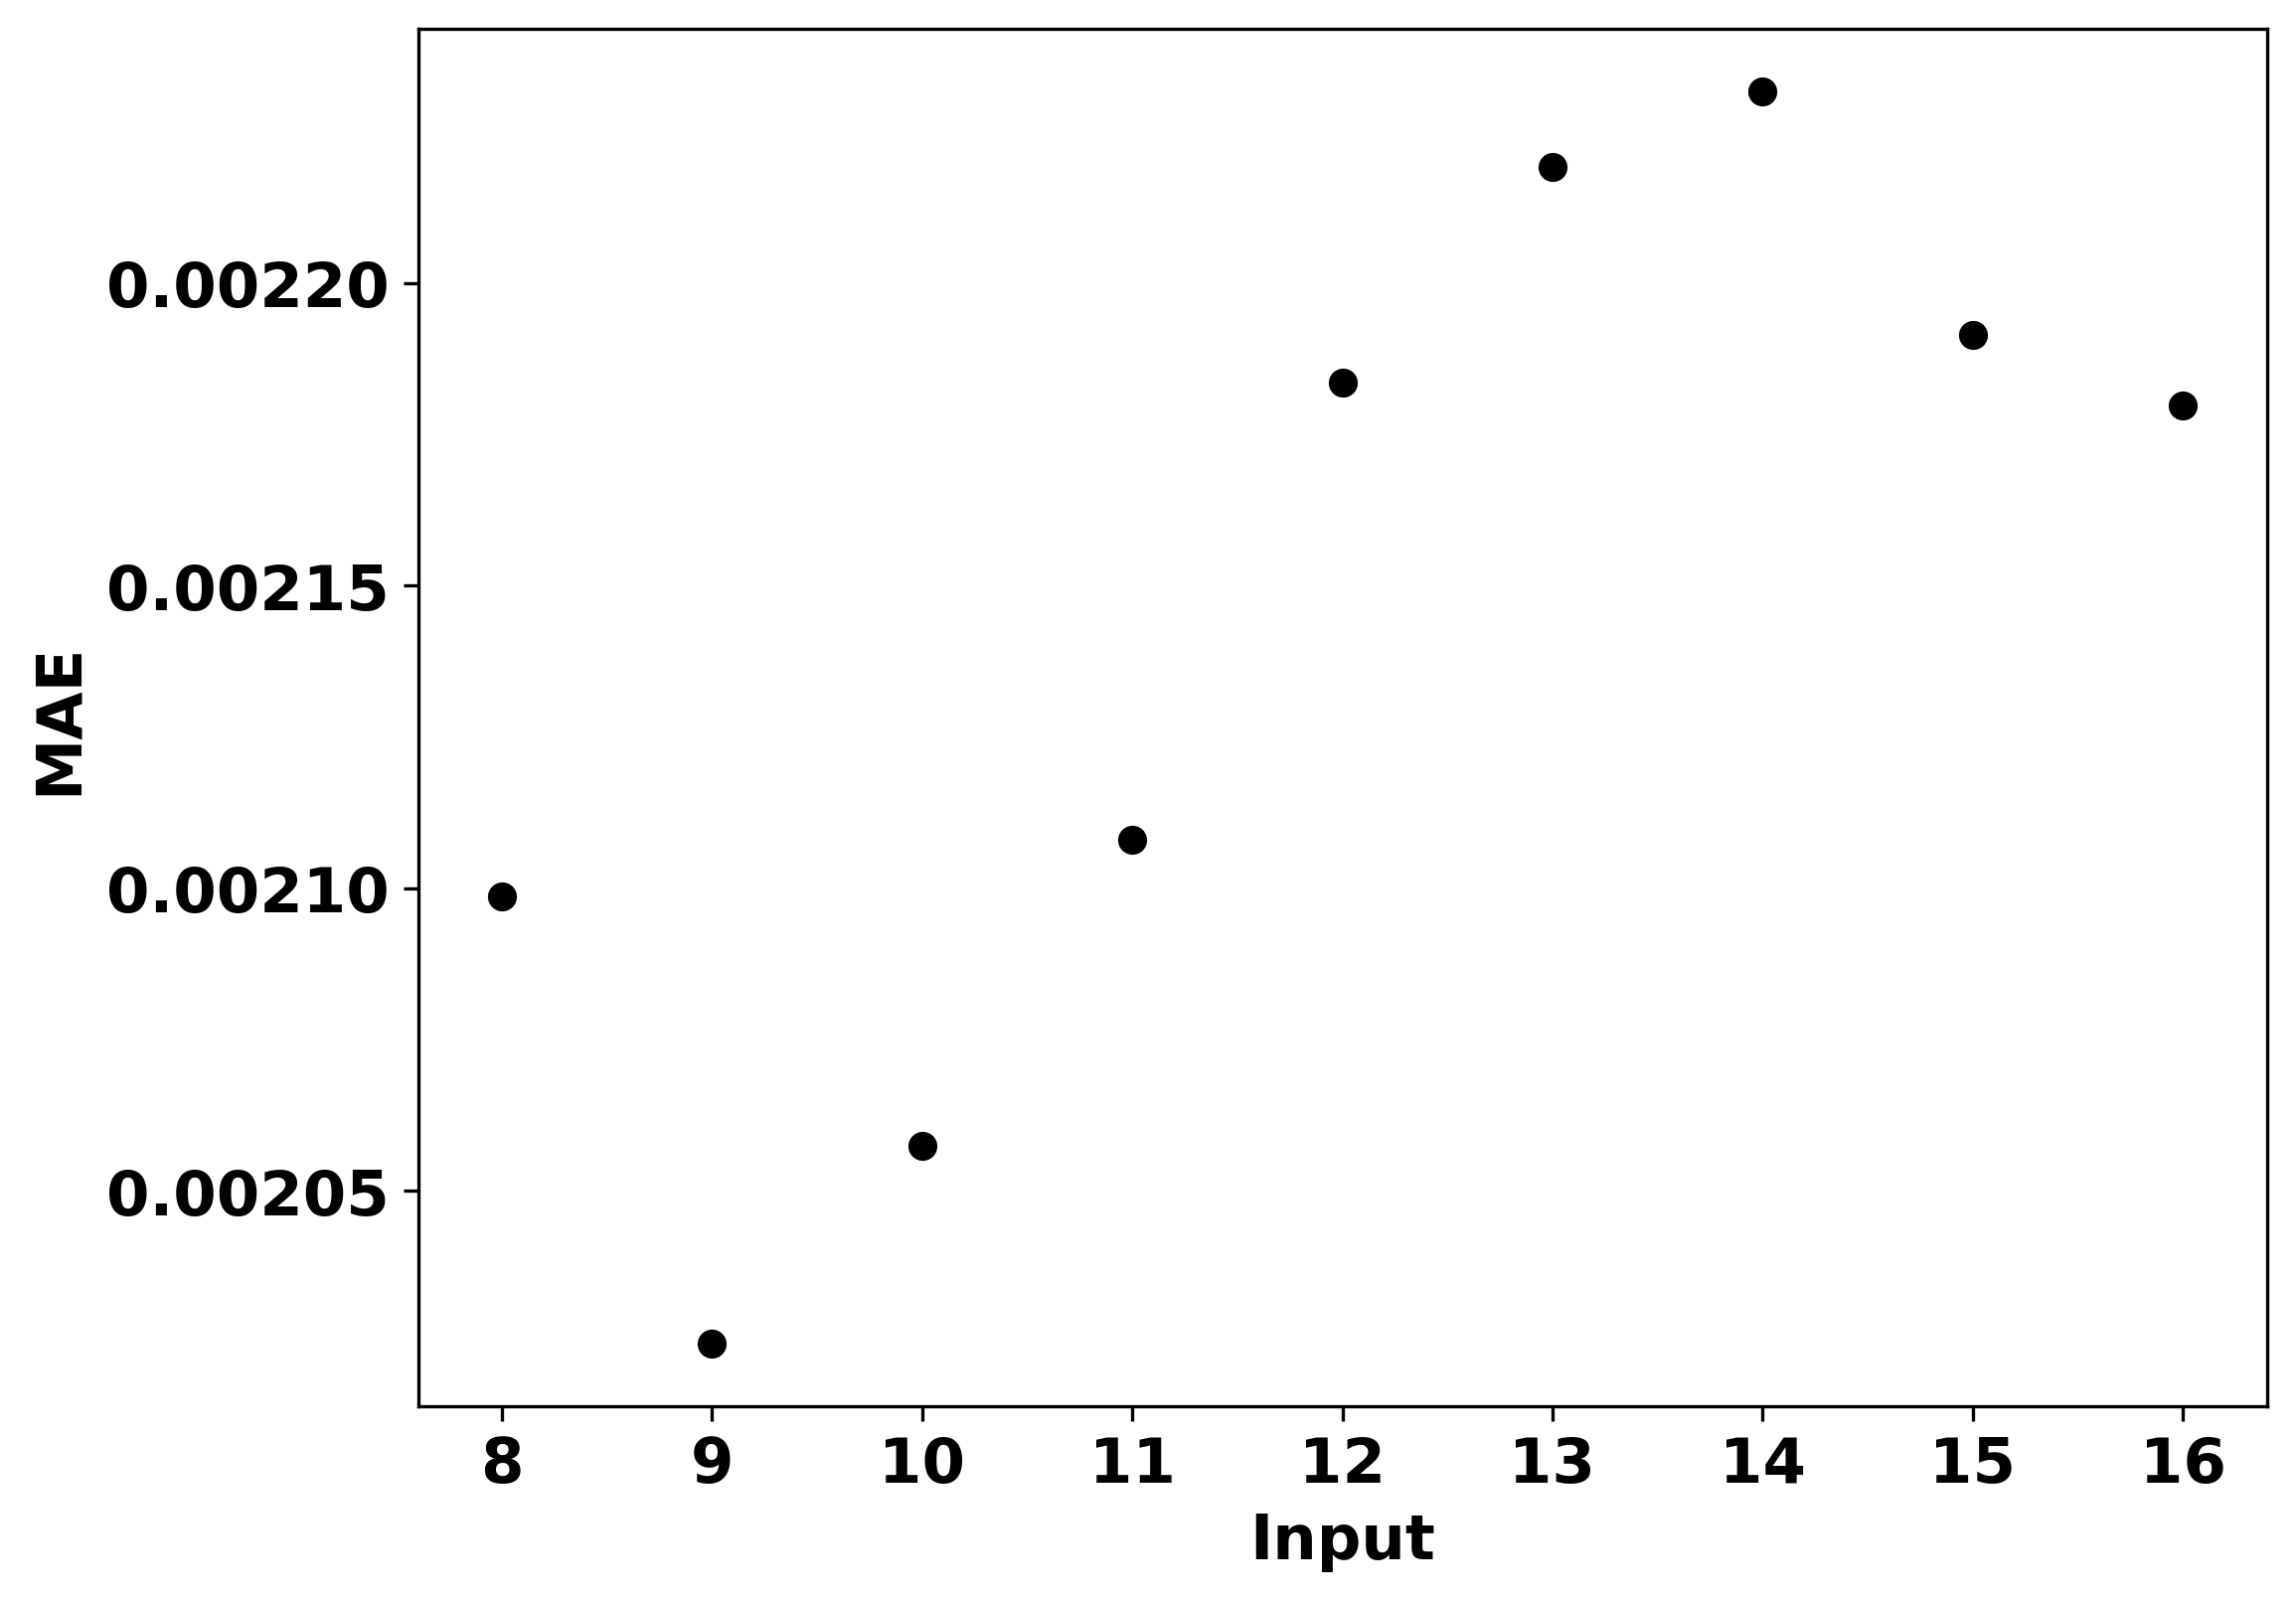

In [ ]:
x = [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

mean_input = np.mean(mae,axis=1)
print(mean_input)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(range(8, 17), mean_input[4:], color="black")
#ax.scatter(4, mean_input[0], color="black")
ax.set_xlabel("Input", fontweight="bold")
ax.set_ylabel("MAE", fontweight="bold")

ax.set_xticks(range(8, 17))
ax.minorticks_off()
plt.show()


[0.00012766 0.00032773 0.00064011 0.00110527 0.00178414 0.00278086
 0.00415283 0.00623209]


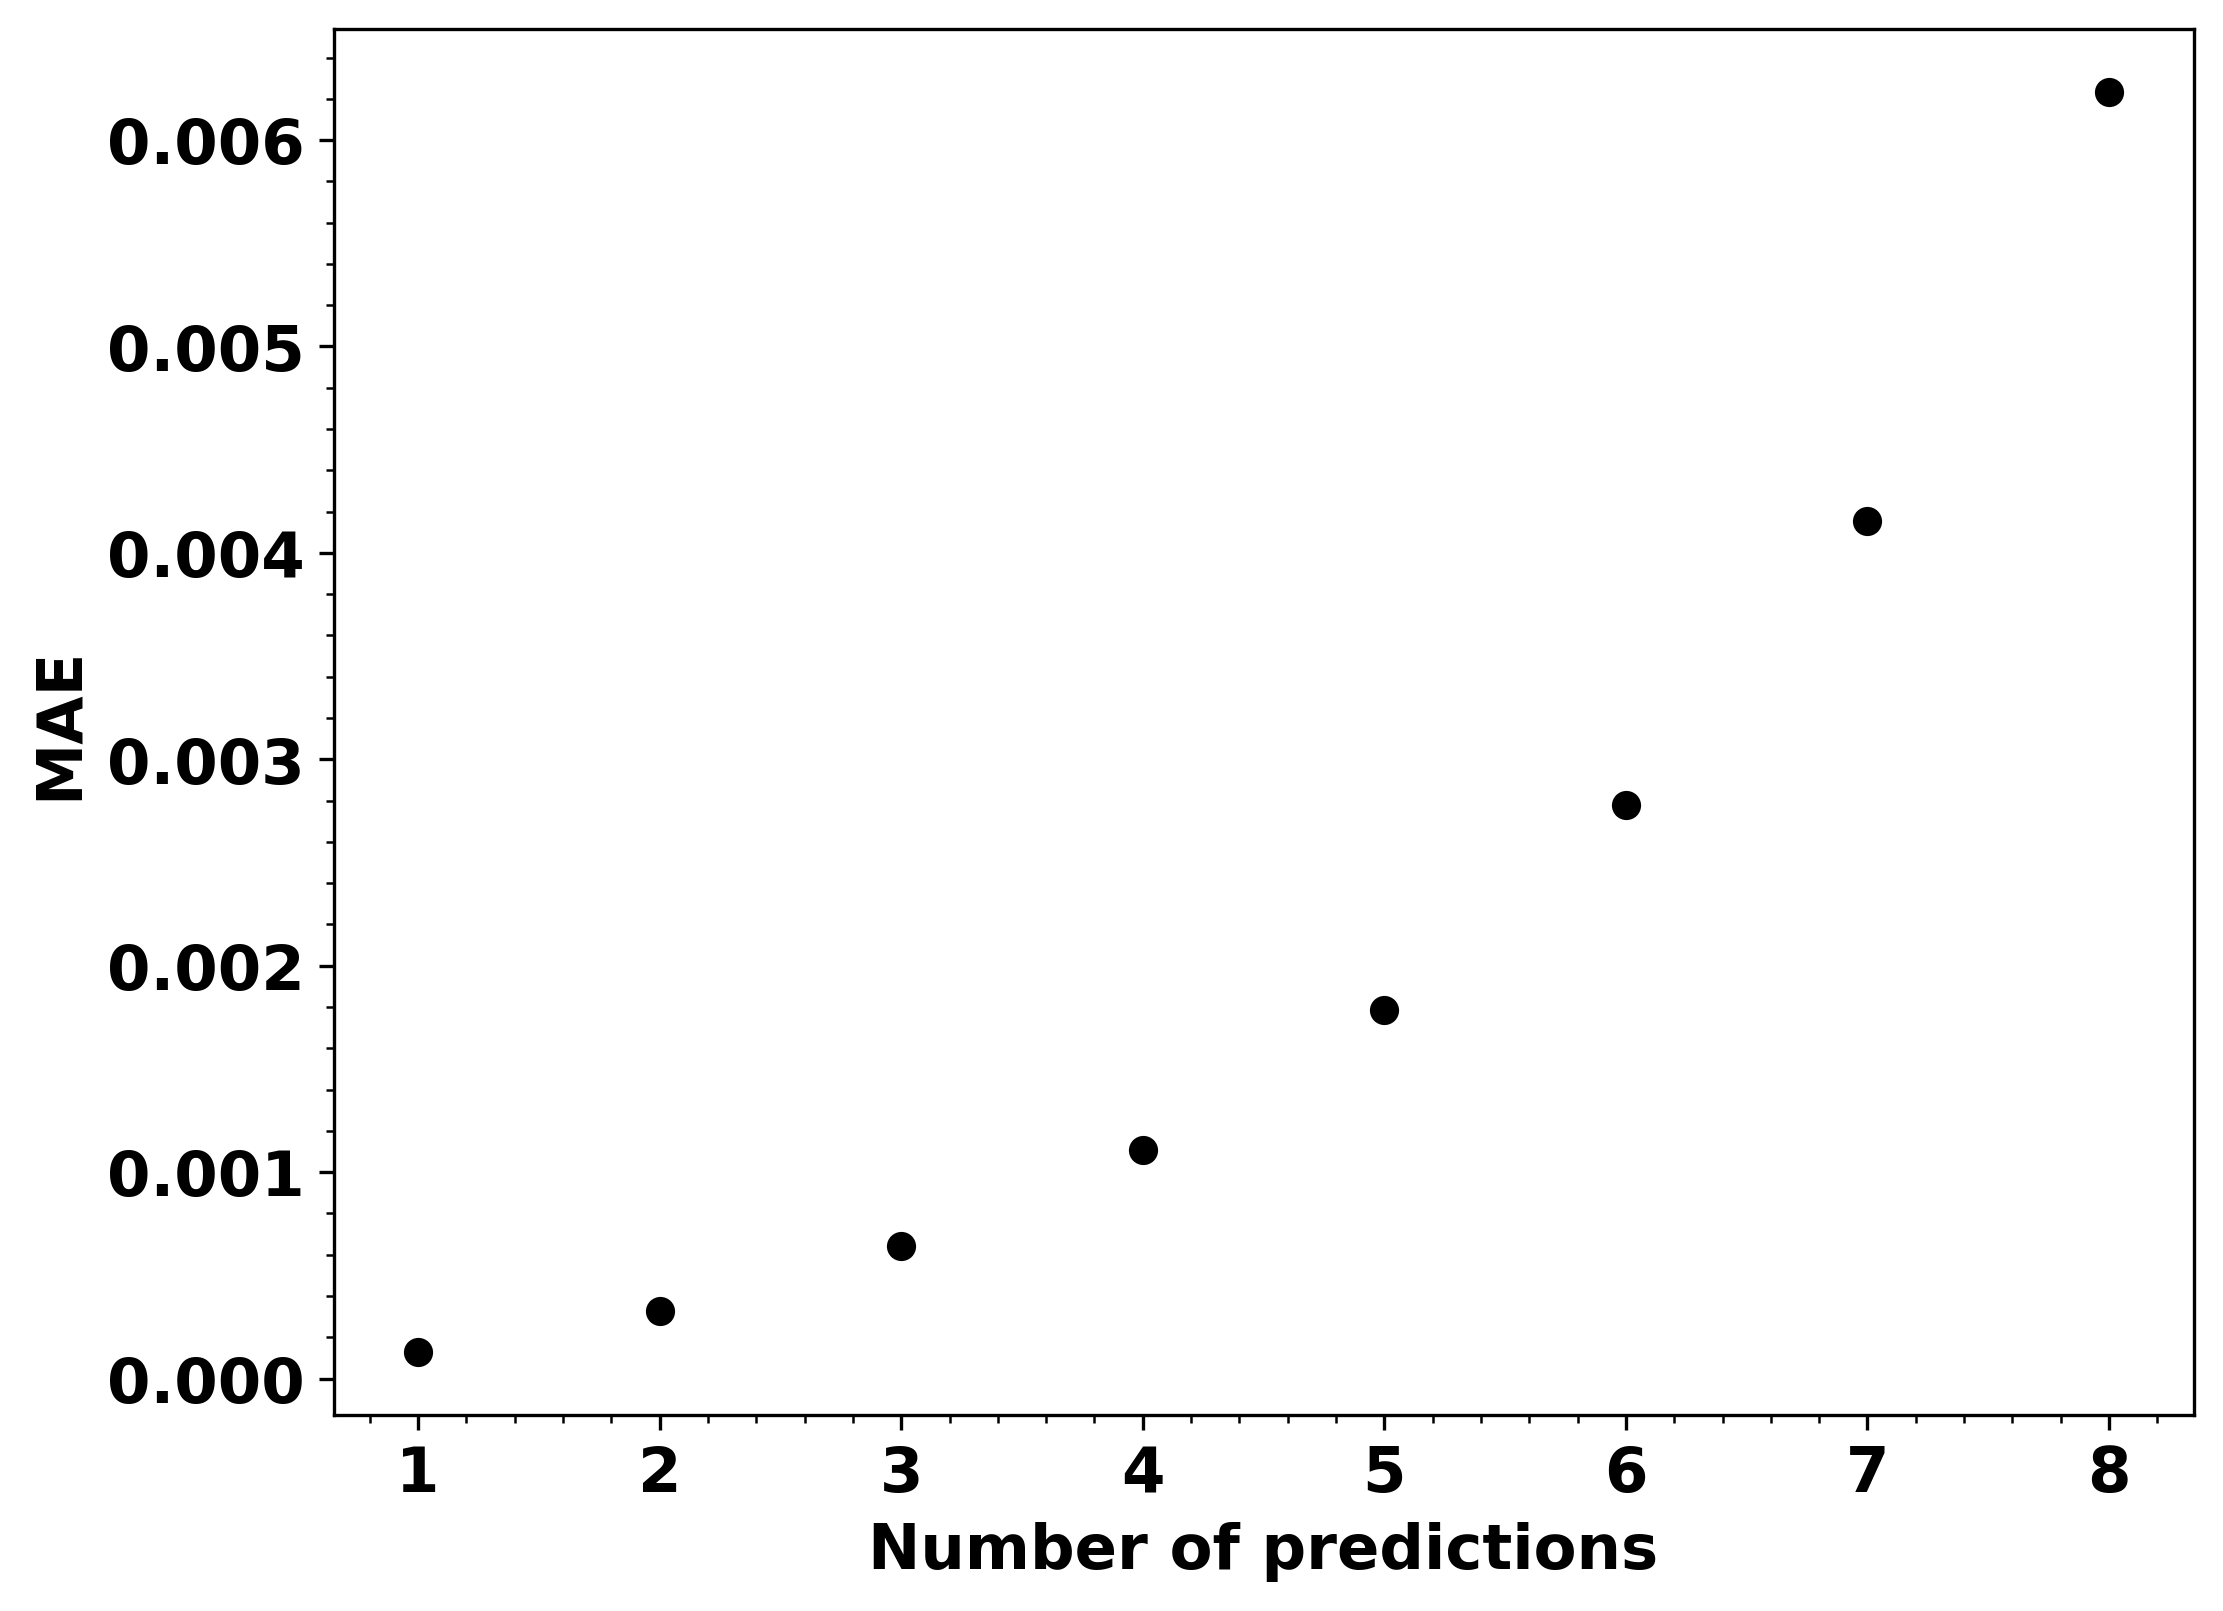

In [ ]:


mean_pred = np.mean(np.delete(mae, [0, 1, 2, 3], axis=0),axis=0)

print(mean_pred)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(range(1, 9), mean_pred, color="black")
ax.set_xlabel("Number of predictions", fontweight="bold")
ax.set_ylabel("MAE", fontweight="bold")
ax.set_xticks(range(1, 9))
ax.minorticks_off
plt.show()